In [1]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# Line 3: Mount Google Drive (to upload your dataset or save models)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!unzip -q "/content/drive/My Drive/Dataset_shortest.zip" -d /content/



replace /content/dataset_shortest/Head_Movement_Allowed/ (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
dataset_path = "/content/dataset_shortest"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(128, 128),
    batch_size=32
)

Found 20146 files belonging to 2 classes.


In [4]:
EPOCHS = 50

# Line 17-18: Get class names
class_names = dataset.class_names
print(class_names)

['Head_Movement_Allowed', 'Head_Movement_Not_Allowed']


In [5]:
len_dataset = len(dataset)
print(f"Total samples: {len_dataset}")

for img, label in dataset.take(1):
    print(img.shape)
    print(label.numpy())

Total samples: 630
(32, 128, 128, 3)
[0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0]


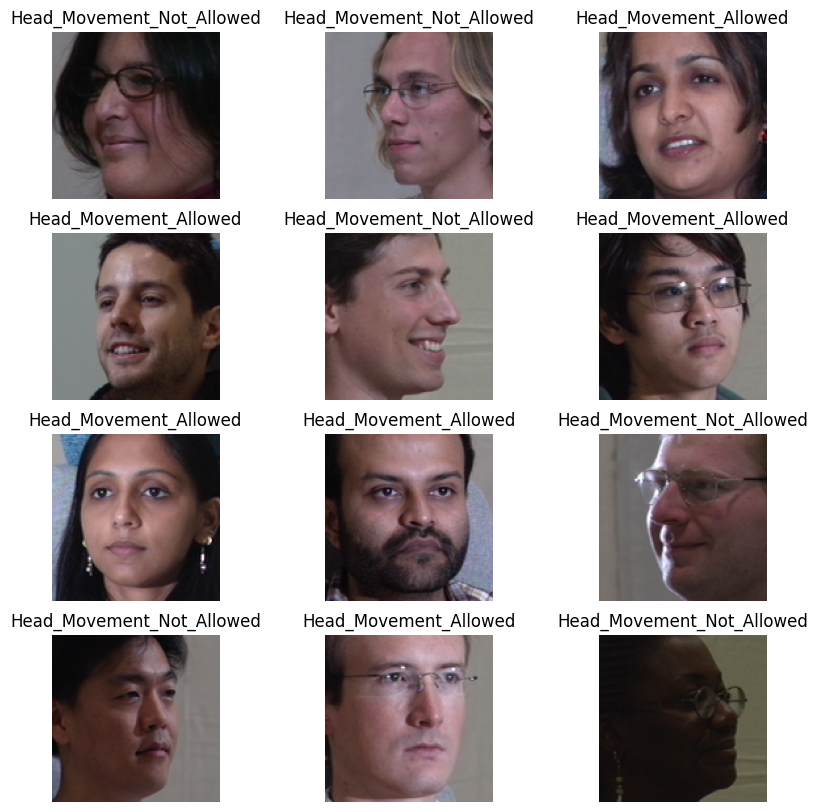

In [6]:
plt.figure(figsize=(10, 10))
for img, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset_size = len(dataset)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [8]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(128, 128),
    tf.keras.layers.Rescaling(1.0 / 255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [11]:
BATCH_SIZE = 32
n_classes = 2

model = models.Sequential([
    layers.InputLayer(input_shape=(128, 128, 3)),  # Image data
    layers.Reshape((128, 128 * 3)),  # Flatten each row into a sequence
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 128, 384)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128, 128)            │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 402,626 (1.54 MB)

 Trainable params: 402,626 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.6165 - loss: 0.6546 - val_accuracy: 0.6230 - val_loss: 0.6392
Epoch 2/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6654 - loss: 0.5985 - val_accuracy: 0.6791 - val_loss: 0.5624
Epoch 3/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6684 - loss: 0.5963 - val_accuracy: 0.6438 - val_loss: 0.6080
Epoch 4/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6737 - loss: 0.5990 - val_accuracy: 0.5625 - val_loss: 0.6831
Epoch 5/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5721 - loss: 0.6734 - val_accuracy: 0.6632 - val_loss: 0.5881
Epoch 6/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6212 - loss: 0.6340 - val_accuracy: 0.6706 - val_loss: 0.5813
Epoch 7/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7169 - loss: 0.5564 - val_accuracy: 0.7812 - val_loss: 0.5217
Epoch 8/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7790 - loss: 0.4807 - val

In [15]:
test_scores = model.evaluate(test_dataset)
test_scores

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9324 - loss: 0.1532


[0.1392740160226822, 0.940559446811676]

In [16]:
train_scores = model.evaluate(train_dataset)
train_scores

504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9345 - loss: 0.1535


[0.14733780920505524, 0.9368799328804016]

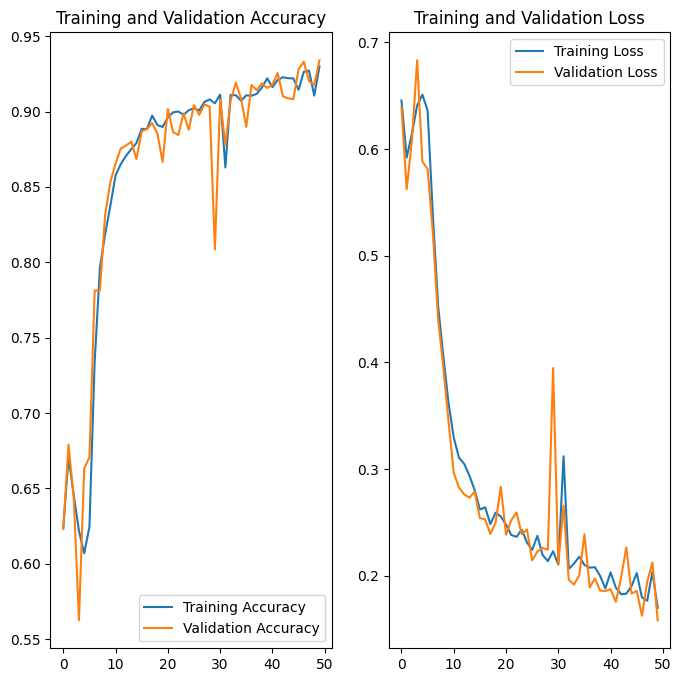

<Figure size 640x480 with 0 Axes>

In [17]:
history_data = history.history
acc = history_data['accuracy']
val_acc = history_data['val_accuracy']
loss = history_data['loss']
val_loss = history_data['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
plt.savefig("Accuracy and Loss of Custom CNN.png")

Actual Label: Head_Movement_Allowed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Predicted Label: Head_Movement_Allowed


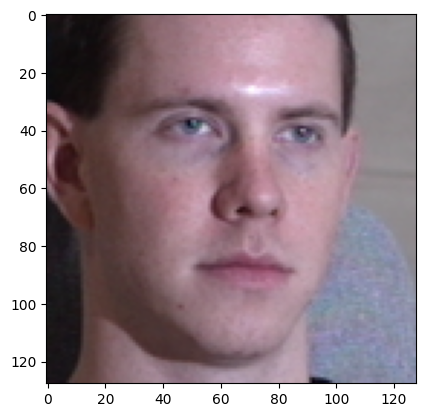

In [18]:
for img, label in test_dataset.take(1):
    first_image = img[0].numpy().astype("uint8")
    first_label = label[0].numpy()

    plt.imshow(first_image, cmap='gray')
    print(f"Actual Label: {class_names[first_label]}")

    batch_prediction = model.predict(img)
    predicted_class = np.argmax(batch_prediction[0])
    print(f"Predicted Label: {class_names[predicted_class]}")

In [19]:
model_version = 'CNN_Model1'
model.save(f"/content/drive/My Drive/{model_version}.keras")
print("Model saved successfully!")

Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

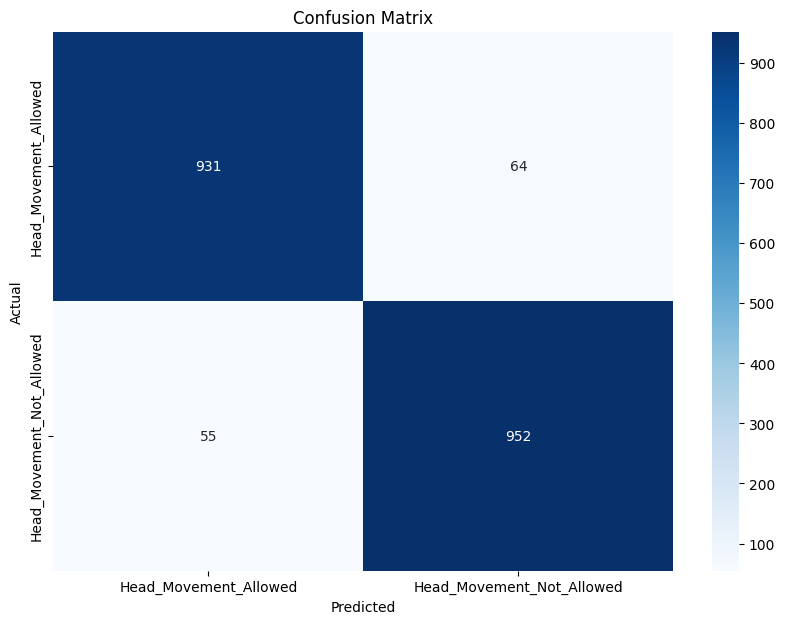

<Figure size 640x480 with 0 Axes>

In [20]:
y_true, y_pred = [], []
for img, label in test_dataset:
    preds = model.predict(img)
    y_true.extend(label.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
plt.savefig("Confusion Matrix of Custom CNN.png")

In [21]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Precision: 0.9405918585096364
Recall: 0.9405594405594405
F1 Score: 0.9405566372932825


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


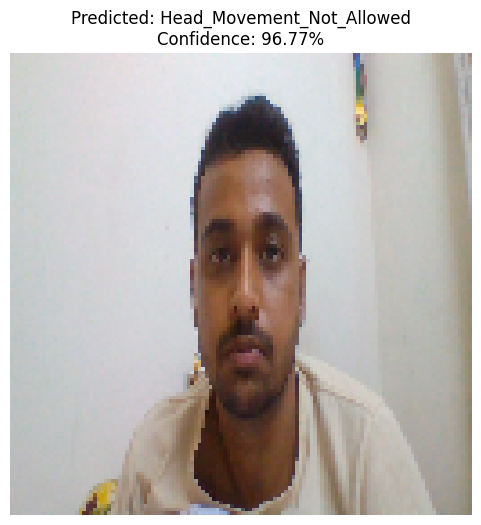

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, img_size=(128, 128)):

    img = image.load_img(img_path, target_size=img_size)  # Load image and resize
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale pixel values to [0, 1]
    return img_array

def predict(model, img):

    predictions = model.predict(img)
    predicted_class = class_names[np.argmax(predictions[0])]  # Get the class name with highest confidence
    confidence = round(100 * (np.max(predictions[0])), 2)  # Get the confidence percentage
    return predicted_class, confidence

# Path to the image on your PC (change this to your own image path)
img_path = '/content/drive/MyDrive/Ray2.jpg'  # Replace with your image path

# Load and preprocess the image
img = load_and_preprocess_image(img_path)

# Predict the class and confidence of the image
predicted_class, confidence = predict(model, img)

# Display the image and the prediction result
plt.figure(figsize=(6,6))
plt.imshow(img[0])  # Display the image (removing the batch dimension)
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
plt.axis('off')  # Hide axes
plt.show()